In [1]:
import pandas as pd
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt
import seaborn as sns
import sys, os



import statsmodels.api as sm
from statsmodels.tsa.arima_model import ARIMA, ARIMAResults
from statsmodels.tsa.arima_process import ArmaProcess
from statsmodels.stats.diagnostic import acorr_ljungbox



from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error


# This one is only available in the development verison of statsmodels
# Run:
#    pip install git+https://github.com/statsmodels/statsmodels.git
# to install the development version.
from statsmodels.tsa.statespace.sarimax import SARIMAX


# grid search sarima hyperparameters
from math import sqrt
from multiprocessing import cpu_count
from joblib import Parallel
from joblib import delayed
from warnings import catch_warnings
from warnings import filterwarnings
from statsmodels.tsa.statespace.sarimax import SARIMAX


from sklearn.metrics import mean_squared_error
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_curve, auc, roc_auc_score, precision_score

from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import AdaBoostRegressor

from sklearn.tree import DecisionTreeRegressor

flatui = ["#5684A0", "#3498db","#9b59b6","#2ecc71" ,"#C93551", "#7EC581", "#D69CC2", "#BEC45F","#FCC38E", "#ED8A4C", "#997474","#8B878D"]
sns.set_palette(flatui) 
sns.set(font_scale = 2)

from scipy import signal
from scipy import stats

sys.path.append("..")
from eda_utilities import print_eda_stats
from data_pipeline import dockless_data_pipeline
from data_pipeline import weather_data_pipeline

In [2]:
dockless_data = pd.read_csv("https://s3.amazonaws.com/sameera-bucket-1/dockless_mobility/raw_data/Austin_Dockless_Vehicle_Trips.csv")
dockless_vehicles_columns = dockless_data.columns
print_eda_stats(dockless_data, dockless_vehicles_columns, "Austin Dockless Mobility Data")
# Call the dockless_data_pipeline()
dockless_data = dockless_data_pipeline(dockless_data)
dockless_vehicles_columns = dockless_data.columns
print_eda_stats(dockless_data, dockless_vehicles_columns, "Austin Dockless Mobility Data")


/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (13) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


+--------------------------+---------+-------------+---------------+--------------+-------------------+
|       Column Name        |  dtype  | Total_Count | Unique_Values | df_totalrows | Null Value counts |
+--------------------------+---------+-------------+---------------+--------------+-------------------+
|            ID            |  object |   2746505   |    2746505    |   2746505    |         0         |
|        Device ID         |  object |   2746505   |     26999     |   2746505    |         0         |
|       Vehicle Type       |  object |   2746504   |       3       |   2746505    |         1         |
|      Trip Duration       | float64 |   2746504   |     10521     |   2746505    |         1         |
|      Trip Distance       | float64 |   2746504   |     16125     |   2746505    |         1         |
|        Start Time        |  object |   2746504   |     25694     |   2746505    |         1         |
|         End Time         |  object |   2746504   |     25768  

In [3]:
#Read the weather data from S3 bucket
weather_data = pd.read_csv("https://s3.amazonaws.com/sameera-bucket-1/dockless_mobility/raw_data/Austin_Bergstom_Airport_Weather.csv")
weather_columns = weather_data.columns
print_eda_stats(weather_data, weather_columns, "Austin Weather Data")
weather_data = weather_data_pipeline(weather_data)
weather_columns = weather_data.columns
print_eda_stats(weather_data, weather_columns, "Austin Weather Data")

+-----------------+---------+-------------+---------------+--------------+-------------------+
|   Column Name   |  dtype  | Total_Count | Unique_Values | df_totalrows | Null Value counts |
+-----------------+---------+-------------+---------------+--------------+-------------------+
|     STATION     |  object |     436     |       1       |     436      |         0         |
|       NAME      |  object |     436     |       1       |     436      |         0         |
|     LATITUDE    | float64 |     436     |       1       |     436      |         0         |
|    LONGITUDE    | float64 |     436     |       1       |     436      |         0         |
|    ELEVATION    | float64 |     436     |       1       |     436      |         0         |
|       DATE      |  object |     436     |      436      |     436      |         0         |
|       AWND      | float64 |     435     |       73      |     436      |         1         |
| AWND_ATTRIBUTES |  object |     435     |       

In [4]:
# Plot the distribution of distances 

trip_distance_value_count = dockless_data['Trip Distance'].value_counts()
trip_distance_value_count = trip_distance_value_count.sort_values(ascending=False)



In [5]:
trip_duration_value_count = dockless_data['Trip Duration'].value_counts()
trip_duration_value_count = trip_duration_value_count.sort_values(ascending=False)

In [6]:
dockless_data['Trip Duration'].max()

1888695.0

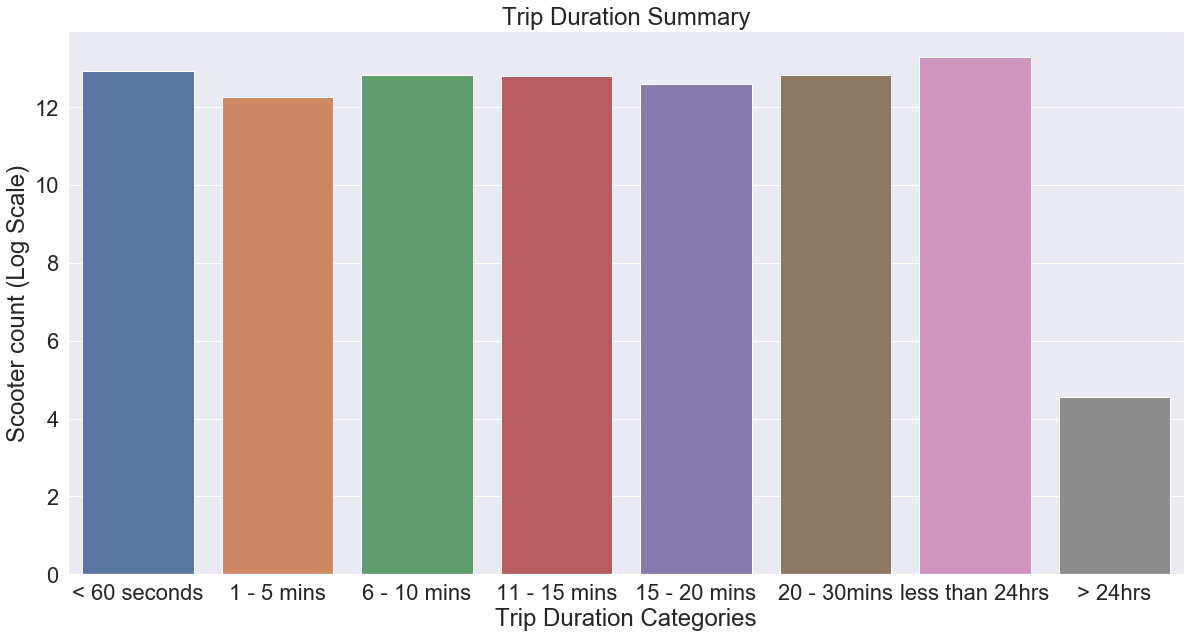

In [32]:
# dockless_data['Trip Duration'].max() -- 1888695.0
dd = pd.DataFrame({'trip_duration':trip_distance_value_count.index, 'count':trip_distance_value_count.values})

bins = [-431.0, 60, 300, 600,900, 1200, 1800, 86400, 1888695]
labels = ['< 60 seconds', '1 - 5 mins','6 - 10 mins' ,'11 - 15 mins', '15 - 20 mins', '20 - 30mins', 'less than 24hrs', '> 24hrs']
dd['category_classes'] = pd.cut(dd['trip_duration'], bins=bins, labels=labels,include_lowest=True, right=True)
prob_groups = dd.groupby(['category_classes'])['count'].sum()

prob_groups_log = np.log(prob_groups)

plt.figure(figsize=(20,10))

# sns.barplot(x=prob_groups.index, y=prob_groups.values)
# plt.title('Trip Duration Summary', fontsize=25)
# plt.ylabel('Scooter count', fontsize=20)
# plt.xlabel('Trip Duration Categories', fontsize=20)
# plt.savefig('../../output/Final/Trip_Duration_Summary.png')

sns.barplot(x=prob_groups_log.index, y=prob_groups_log.values)
plt.title('Trip Duration Summary')
plt.ylabel('Scooter count (Log Scale)')
plt.xlabel('Trip Duration Categories')
plt.savefig('../../output/Final/Trip_Duration__Log_Summary.png')

plt.show()

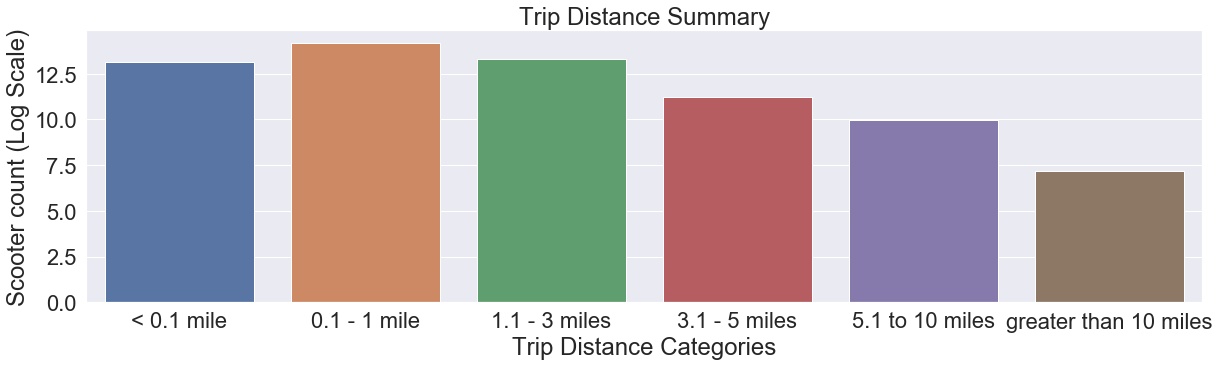

In [33]:
sns.set(font_scale = 2)
dd = pd.DataFrame({'trip_distance':trip_distance_value_count.index, 'count':trip_distance_value_count.values})

bins2 = [-16724106.0, 161, 1601, 4828,8047, 16093, 804672]
labels2 = ['< 0.1 mile', '0.1 - 1 mile','1.1 - 3 miles' ,'3.1 - 5 miles', '5.1 to 10 miles', 'greater than 10 miles']
dd['category_classes'] = pd.cut(dd['trip_distance'], bins=bins2, labels=labels2, include_lowest=True, right=True)

prob_groups = dd.groupby(['category_classes'])['count'].sum()

prob_groups_log = np.log(prob_groups)

plt.figure(figsize=(20,5))

# sns.barplot(x=prob_groups.index, y=prob_groups.values)
# plt.title('Trip Distance Summary')
# plt.ylabel('Scooter count')
# plt.xlabel('Trip Distance Categories')
# plt.savefig('../../output/Final/Trip_Distance_Summary.png')

sns.barplot(x=prob_groups_log.index, y=prob_groups_log.values)
plt.title('Trip Distance Summary')
plt.ylabel('Scooter count (Log Scale)')
plt.xlabel('Trip Distance Categories')
plt.savefig('../../output/Final/Trip_Distance_Logarithmic_Summary.png')

plt.show()


In [11]:
# TODO : Add to pipeline
# Drop all records where  trip distance is less .1 miles and greater than 500 miles (160.934 mts - 804673 mts)
dockless_data = dockless_data[(dockless_data['Trip Distance'] > 160.934) & (dockless_data['Trip Distance'] < 804673)]
dockless_data = dockless_data[(dockless_data['Trip Duration'] > 60) & (dockless_data['Trip Duration'] < 86400)]

In [12]:
# TODO : Add to pipeline
# Have only weather data which is from the start date of the scooter data
trip_counts = dockless_data.groupby('START_DATE').count()['count']
weather_data= weather_data[weather_data['DATE'] >= trip_counts.index.min()]
weather_data= weather_data[weather_data['DATE'] <= trip_counts.index.max()]


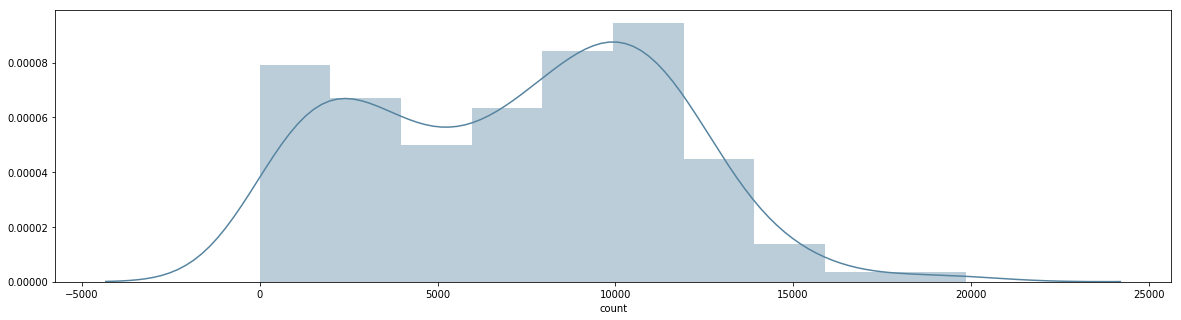

In [14]:
plt.figure(figsize=(20,5))
sns.distplot(trip_counts);
plt.show()

# plt.title('Destination Cell Counts - Top 50')
# plt.ylabel('Number of Occurrences', fontsize=12)
# plt.xlabel('Destination Cell ID', fontsize=12,rotation='horizontal')
# plt.xticks(rotation=90)
# plt.savefig('../output/EDA/Destination_Cell_Counts_Top_50.png')
# plt.show()

In [15]:
hourly = dockless_data.resample('H').sum()


In [16]:
total_trip_counts = dockless_data.groupby('Start Time').count()['count']

In [17]:
total_trip_counts.head(5)

Start Time
2018-04-03 18:30:00    1
2018-04-04 15:45:00    1
2018-04-04 17:15:00    1
2018-04-05 05:00:00    1
2018-04-05 08:30:00    2
Name: count, dtype: int64

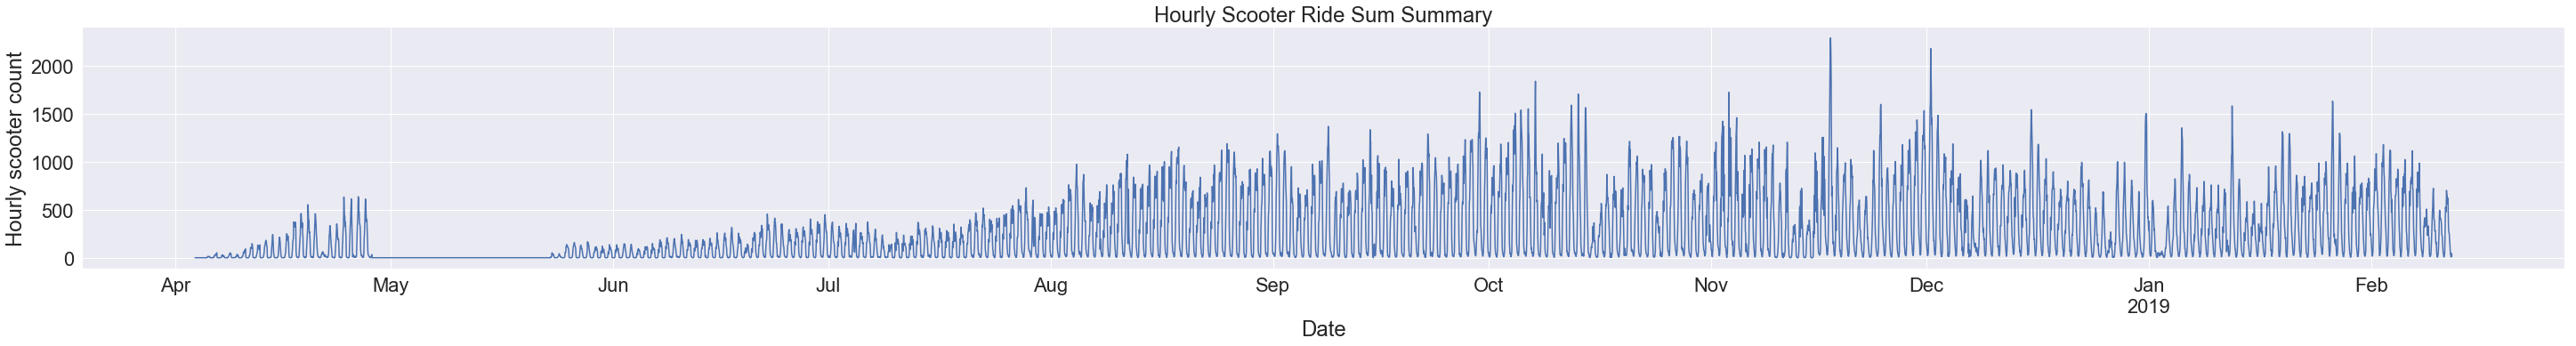

In [39]:
hourly = total_trip_counts.resample('H').sum()
hourly.plot(style=['-', '--', ':'],figsize=(50, 5))
plt.title('Hourly Scooter Ride Sum Summary')
plt.ylabel('Hourly scooter count')
plt.xlabel("Date")
plt.savefig('../../output/Final/Hourly_Scooter_Total_expanded.png')

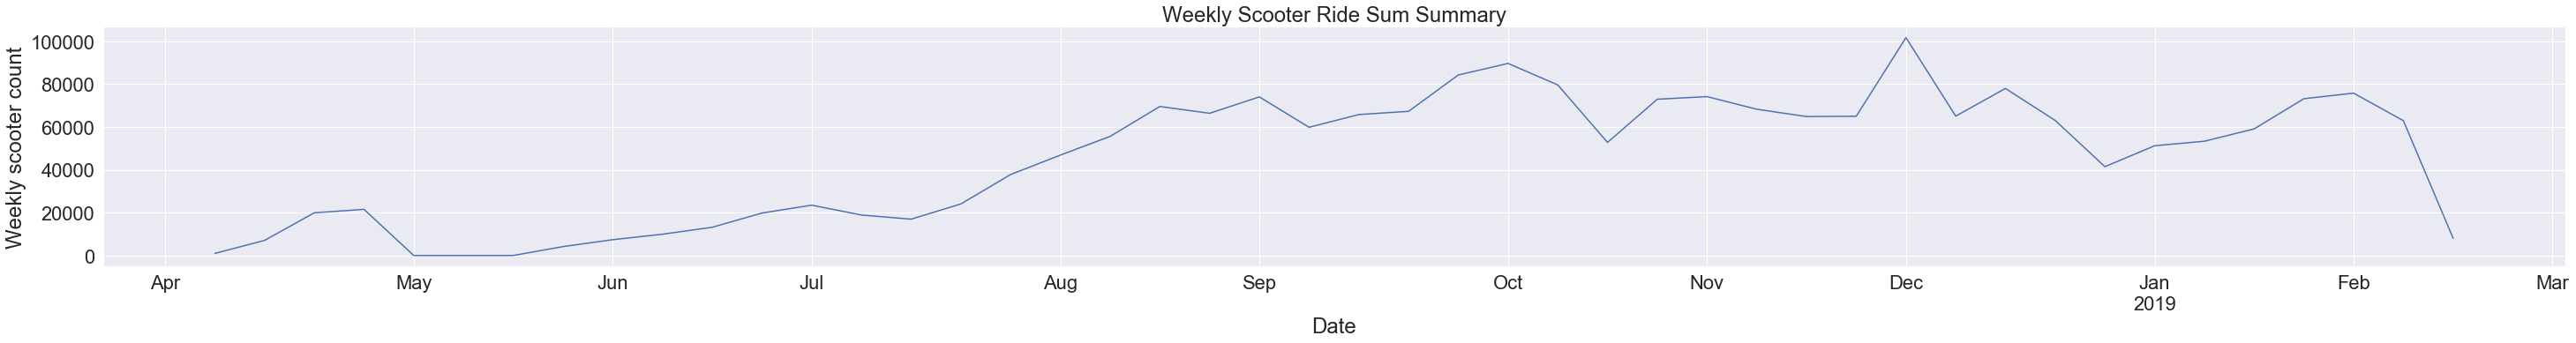

In [40]:
hourly = total_trip_counts.resample('W').sum()
hourly.plot(style=['-', '--', ':'],figsize=(50, 5))
plt.title('Weekly Scooter Ride Sum Summary')
plt.ylabel('Weekly scooter count')
plt.xlabel("Date")
plt.savefig('../../output/Final/Weekly_Scooter_Total_expanded.png')

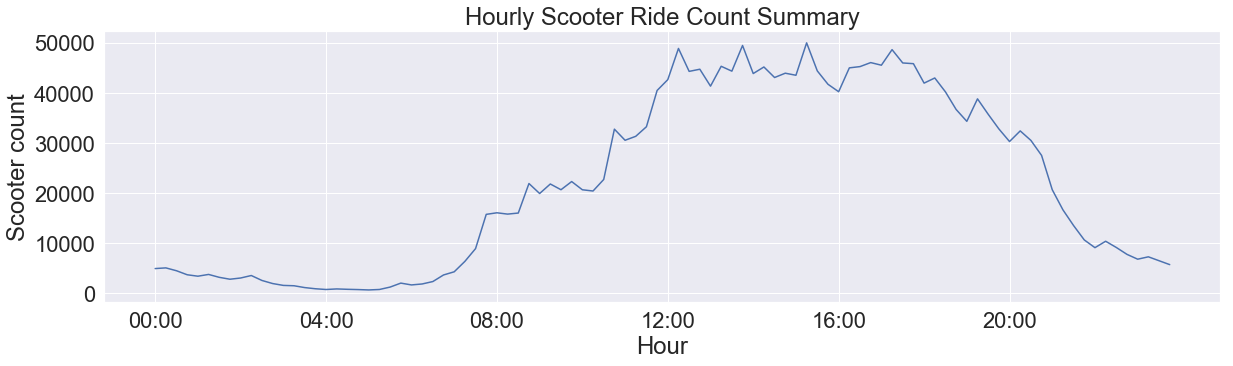

In [44]:
by_time = total_trip_counts.groupby(total_trip_counts.index.time).sum()
hourly_ticks = 4 * 60 * 60 * np.arange(6)
by_time.plot(xticks=hourly_ticks, style=['-', '--', ':'],figsize=(20, 5));
plt.title('Hourly Scooter Ride Count Summary')
plt.ylabel('Scooter count')
plt.xlabel("Hour")
#plt.xlabel('Month', fontsize=12,rotation='horizontal')
#plt.xticks(rotation=90)
plt.savefig('../../output/Final/Hour_Scooter_Top_10.png')
plt.show()

In [90]:
weather_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 316 entries, 92 to 407
Data columns (total 7 columns):
DATE                    316 non-null object
AVG_DAILY_WIND_SPEED    316 non-null float64
PRECIPITATION           316 non-null float64
SNOW                    316 non-null float64
AVG_TEMPERATURE         316 non-null float64
MAX_TEMPERATURE         316 non-null float64
MIN_TEMPERATURE         316 non-null float64
dtypes: float64(6), object(1)
memory usage: 19.8+ KB


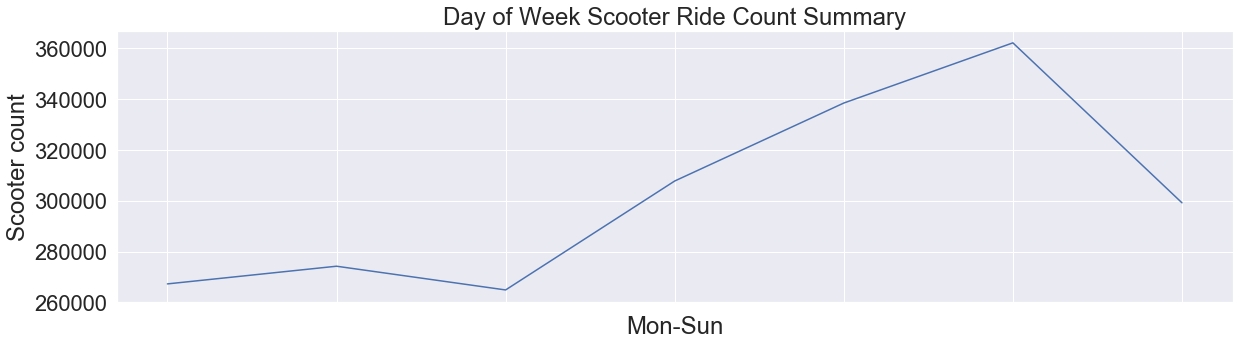

In [56]:
fig.set_size_inches(18.5, 10.5, forward=True)
by_weekday = total_trip_counts.groupby(total_trip_counts.index.dayofweek).sum()
by_weekday.index = ['Mon', 'Tues', 'Wed', 'Thurs', 'Fri', 'Sat', 'Sun']
by_weekday.plot(style=['-', '--', ':'],figsize=(20, 5));
plt.title('Day of Week Scooter Ride Count Summary')
plt.ylabel('Scooter count')
plt.xlabel('Mon-Sun',rotation='horizontal')
plt.xticks(rotation=90)
plt.savefig('../../output/Final/Day_of_Week_Scooter_Top_10.png')
plt.show()

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:16: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  app.launch_new_instance()


<Figure size 432x288 with 0 Axes>

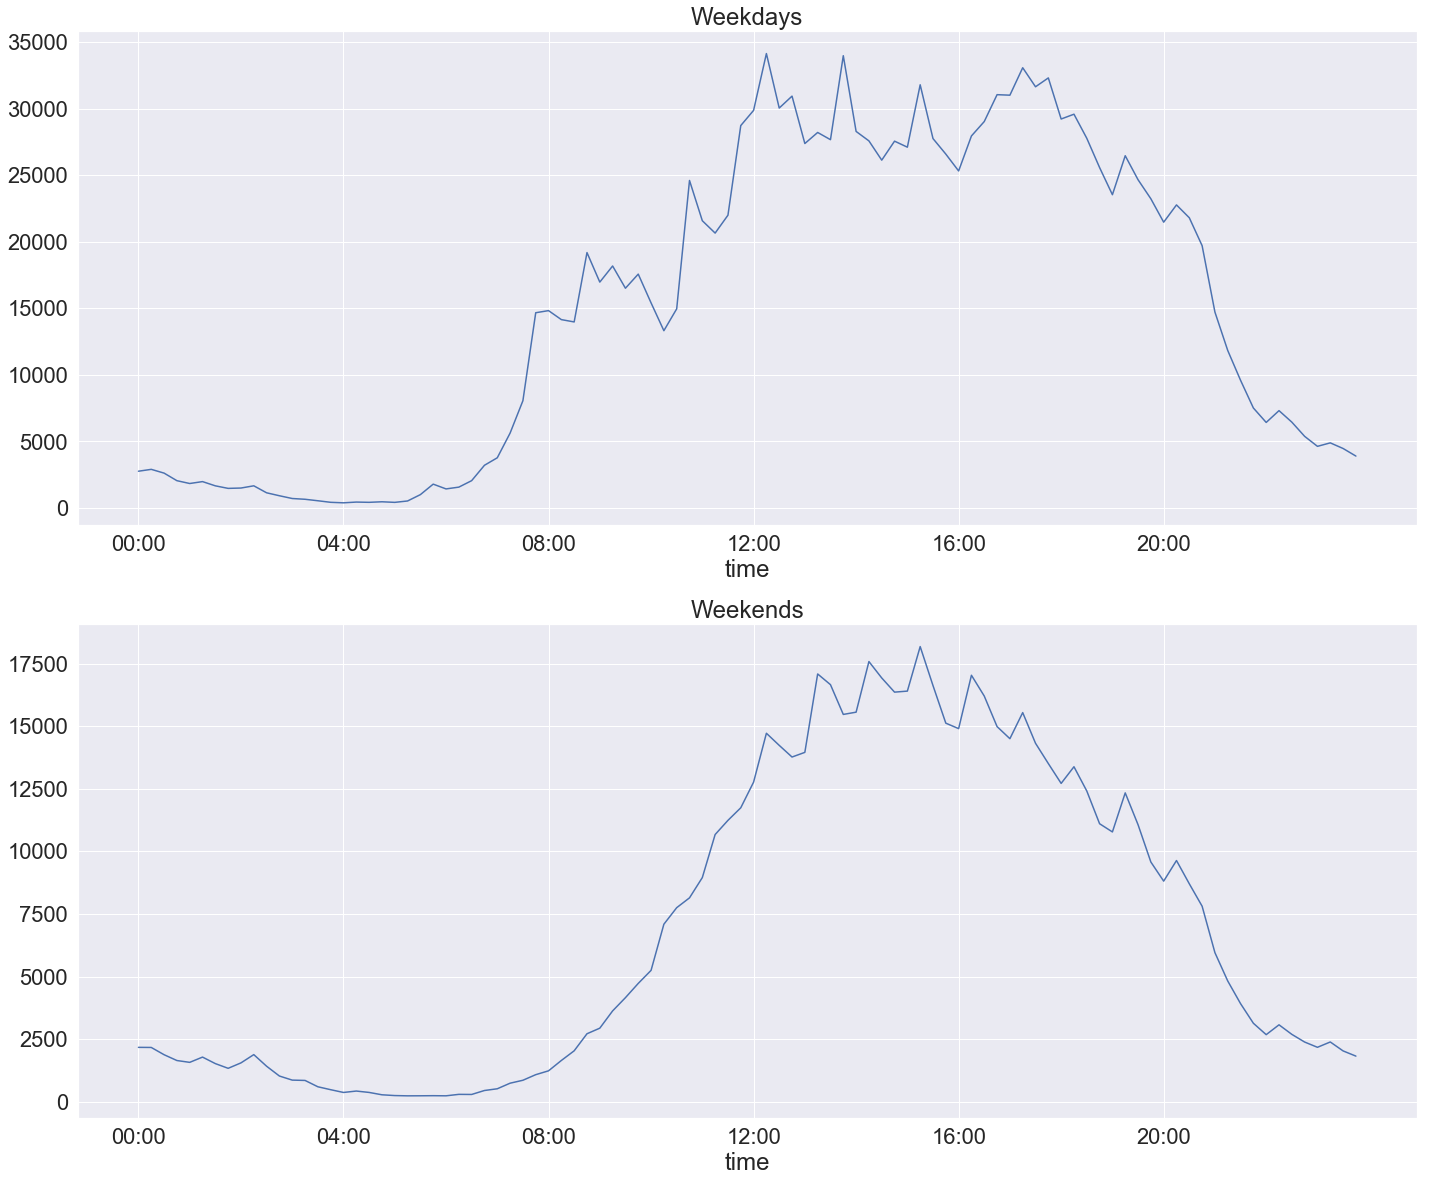

In [65]:
'''
This shows a strong distinction between weekday and weekend totals, 
with around twice as many average riders crossing the bridge on Monday through Friday than on Saturday and Sunday.

With this in mind, let's do a compound GroupBy and look at the hourly trend on weekdays versus weekends. 
We'll start by grouping by both a flag marking the weekend, and the time of day:
'''
weekend = np.where(total_trip_counts.index.weekday < 5, 'Weekday', 'Weekend')
by_time = total_trip_counts.groupby([weekend, total_trip_counts.index.time]).sum()

plt.subplots_adjust(bottom = 1.1,top = 1.9,wspace = 0.2,hspace = 0.2)

fig, ax = plt.subplots(2, 1, figsize=(24, 20))
by_time.ix['Weekday'].plot(ax=ax[0], title='Weekdays',
                           xticks=hourly_ticks, style=['-', '--', ':'])
by_time.ix['Weekend'].plot(ax=ax[1], title='Weekends',
                           xticks=hourly_ticks, style=['-', '--', ':']);
plt.savefig('../../output/Final/Weekday_Weekend_Ridership.png')
plt.show()

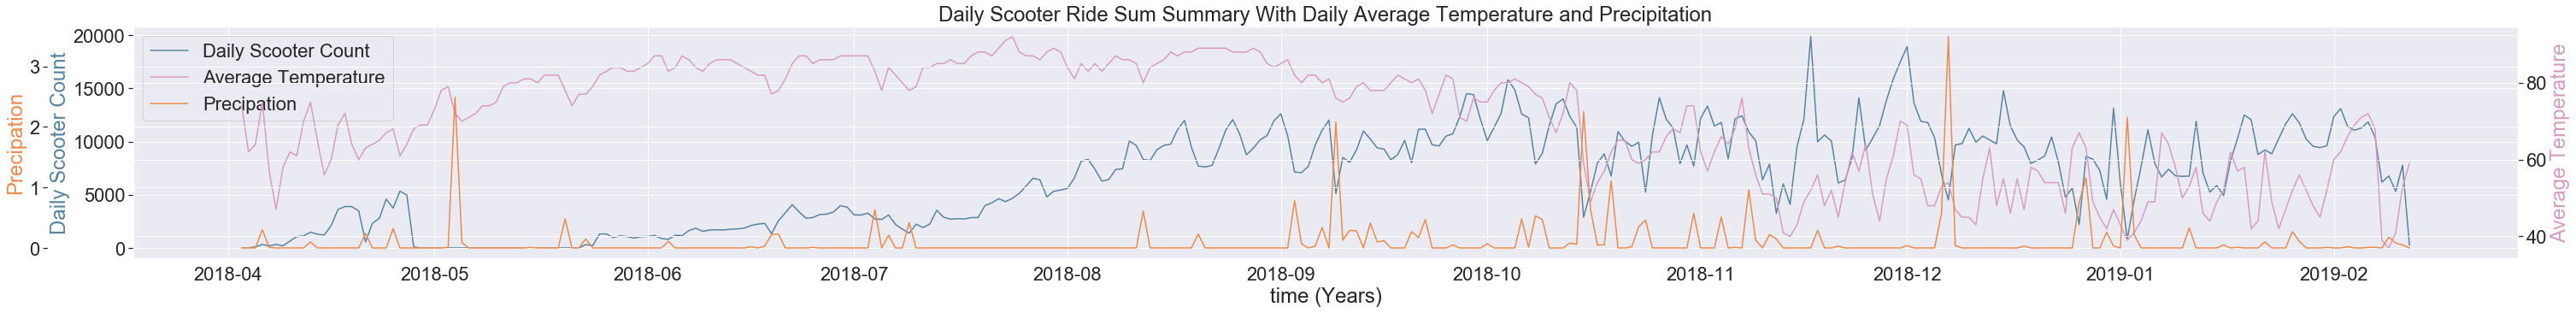

In [67]:
from mpl_toolkits.axes_grid1 import host_subplot
import mpl_toolkits.axisartist as AA
import matplotlib.pyplot as plt

#host = host_subplot(111, axes_class=AA.Axes)

#fig, host = plt.subplots(nrows=1, ncols=1,figsize=(50, 5))

fig, ax = plt.subplots(figsize=(50,5))


#plt.subplots_adjust(right=0.75)
#ax = ax.flatten()
par1 = ax.twinx()
par2 = ax.twinx()

offset = 60



color1 = "#5684A0"
color2 = "#D69CC2"
color3 = "#ED8A4C"


flatui = ["#5684A0", "#3498db","#9b59b6","#2ecc71" ,"#C93551", "#7EC581", "#D69CC2", "#BEC45F","#FCC38E", "#ED8A4C", "#997474","#8B878D"]
#sns.palplot(sns.color_palette(flatui))
# flatui = ["#9b59b6", "#3498db", "#95a5a6", "#e74c3c", "#34495e", "#2ecc71"]
# sns.palplot(sns.color_palette(flatui))


'''
p1, = host.plot([0, 1, 2], [0, 1, 2], color=color1,label="Density")
p2, = par1.plot([0, 1, 2], [0, 3, 2], color=color2, label="Temperature")
p3, = par2.plot([0, 1, 2], [50, 30, 15], color=color3, label="Velocity")

lns = [p1, p2, p3]
host.legend(handles=lns, loc='best')

# right, left, top, bottom
par2.spines['right'].set_position(('outward', 60))      
# no x-ticks                 
par2.xaxis.set_ticks([])
# Sometimes handy, same for xaxis
#par2.yaxis.set_ticks_position('right')

host.yaxis.label.set_color(p1.get_color())
par1.yaxis.label.set_color(p2.get_color())
par2.yaxis.label.set_color(p3.get_color())

plt.savefig("pyplot_multiple_y-axis.png", bbox_inches='tight')

'''


ax.set_ylabel("Daily Scooter Count")
par1.set_ylabel("Temperature")
par2.set_ylabel("Precipation")

par2.spines['left'].set_position(('outward', 100)) 
par2.spines["left"].set_visible(True) 
par2.yaxis.set_label_position('left') 
par2.yaxis.set_ticks_position('left')

p1, = ax.plot(daily.index, daily.values, color=color1, label="Daily Scooter Count")
p2, = par1.plot(weather_data.DATE, weather_data.AVG_TEMPERATURE.values,color=color2, label="Average Temperature")
p3, = par2.plot(weather_data.DATE, weather_data.PRECIPITATION.values,color=color3,  label="Precipation")

lns = [p1, p2, p3]
ax.legend(handles=lns, loc='best')


par2.spines['right'].set_position(('outward', 60)) 
# no x-ticks                 
#par2.xaxis.set_ticks([])
ax.set_ylabel('Daily Scooter Count', color=color1)
par1.set_ylabel('Average Temperature', color=color2)
par2.set_ylabel('Precipation', color=color3)

plt.title('Daily Scooter Ride Sum Summary With Daily Average Temperature and Precipitation')
ax.set_xlabel('time (Years)')

plt.savefig("../../output/Final/Total_Sccoter_Temp_Precip.png")
plt.show()

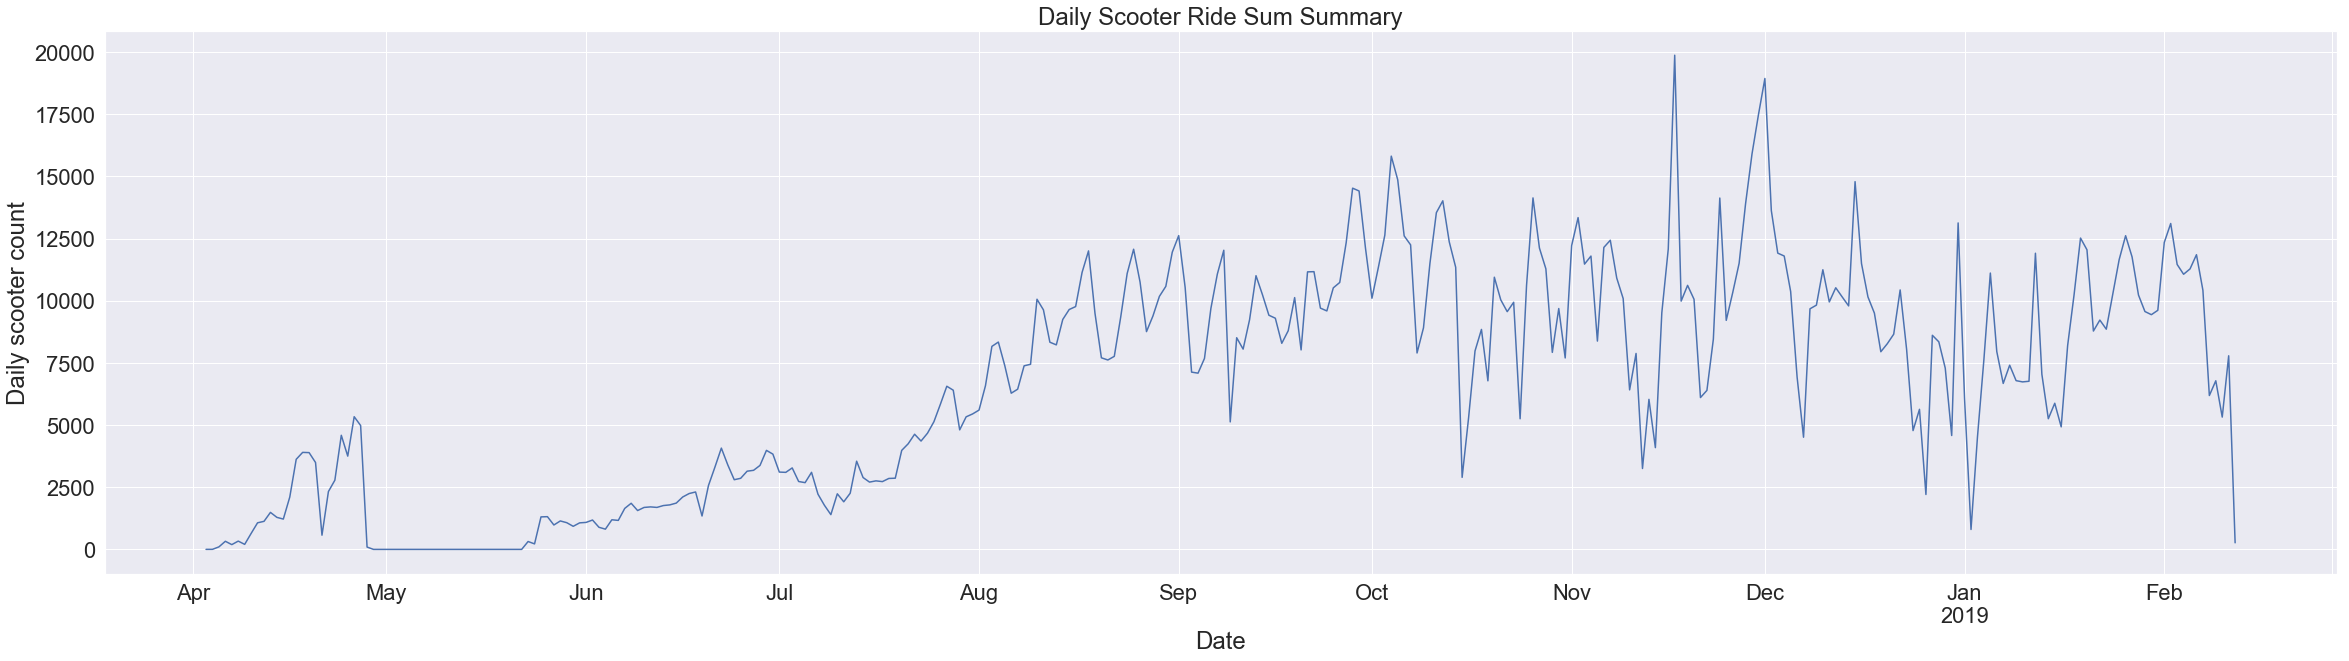

In [70]:
daily = total_trip_counts.resample('D').sum()
daily.plot(style=['-', '--', ':'],figsize=(40, 10))
plt.title('Daily Scooter Ride Sum Summary')
plt.ylabel('Daily scooter count')
plt.xlabel('Date')
plt.savefig('../../output/Final/Daily_Scooter_Total_expanded.png')

In [120]:
#hourly = dockless_data.resample('H').sum()

nov_15_dec_15 = dockless_data[(dockless_data.index > start_date)]
nov_15_dec_15 = nov_15_dec_15[(nov_15_dec_15.index <= '2018-12-10')]

start_date = dt.date(2018,11,30)
end_date = dt.date(2018,12,10)


weather_data_nov_15_dec_15 = weather_data[(weather_data.DATE > start_date) & (weather_data.DATE <= end_date)]
#weather_data_nov_15_dec_15 = weather_data_nov_15_dec_15[(weather_data_nov_15_dec_15 <= end_date)]
nov_15_dec_15.tail(10)

nov_15_dec_15_daily = nov_15_dec_15.resample('D').sum()
count_nov_15_dec_15_daily = nov_15_dec_15_daily['count']

TypeError: <class 'datetime.date'> type object 2018-11-30

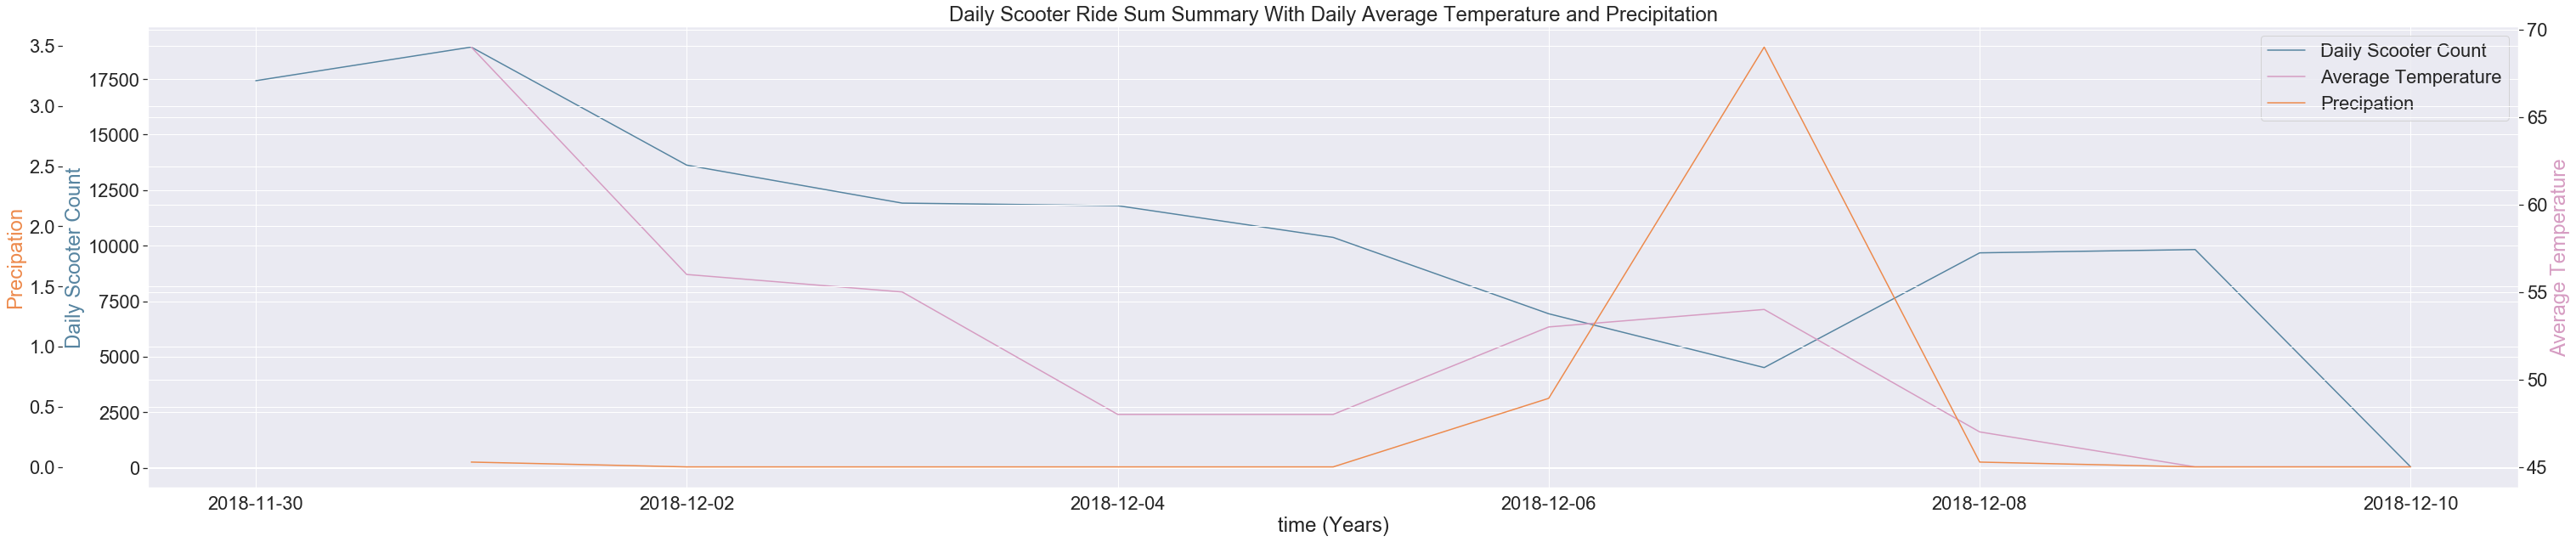

In [119]:
# Plot only subsection of the data

from mpl_toolkits.axes_grid1 import host_subplot
import mpl_toolkits.axisartist as AA
import matplotlib.pyplot as plt


fig, ax = plt.subplots(figsize=(50,10))

par1 = ax.twinx()
par2 = ax.twinx()

offset = 60

color1 = "#5684A0"
color2 = "#D69CC2"
color3 = "#ED8A4C"


flatui = ["#5684A0", "#3498db","#9b59b6","#2ecc71" ,"#C93551", "#7EC581", "#D69CC2", "#BEC45F","#FCC38E", "#ED8A4C", "#997474","#8B878D"]
#sns.palplot(sns.color_palette(flatui))
# flatui = ["#9b59b6", "#3498db", "#95a5a6", "#e74c3c", "#34495e", "#2ecc71"]
# sns.palplot(sns.color_palette(flatui))



ax.set_ylabel("Daily Scooter Count")
par1.set_ylabel("Temperature")
par2.set_ylabel("Precipation")

par2.spines['left'].set_position(('outward', 100)) 
par2.spines["left"].set_visible(True) 
par2.yaxis.set_label_position('left') 
par2.yaxis.set_ticks_position('left')

p1, = ax.plot(nov_15_dec_15_daily.index, count_nov_15_dec_15_daily, color=color1, label="Daily Scooter Count")
p2, = par1.plot(weather_data_nov_15_dec_15.DATE, weather_data_nov_15_dec_15.AVG_TEMPERATURE.values,color=color2, label="Average Temperature")
p3, = par2.plot(weather_data_nov_15_dec_15.DATE, weather_data_nov_15_dec_15.PRECIPITATION.values,color=color3,  label="Precipation")

lns = [p1, p2, p3]
ax.legend(handles=lns, loc='best')

par2.spines['right'].set_position(('outward', 60)) 

ax.set_ylabel('Daily Scooter Count', color=color1)
par1.set_ylabel('Average Temperature', color=color2)
par2.set_ylabel('Precipation', color=color3)

plt.title('Daily Scooter Ride Sum Summary With Daily Average Temperature and Precipitation')
ax.set_xlabel('time (Years)')

plt.savefig("../../output/EDA/Total_Sccoter_Temp_Precip_Subset.png")
plt.show()



#### Univariate Time Series 

In [29]:
def plot_trend_data(ax, name, series):
    ax.plot(series.index, series)
    ax.set_title("Dockless Scooter Trend For {}".format(name))

def to_col_vector(arr):
    """Convert a one dimensional numpy array to a column vector."""
    return arr.reshape(-1, 1)

def make_design_matrix(arr):
    """Construct a design matrix from a numpy array, including an intercept term."""
    return sm.add_constant(to_col_vector(arr), prepend=False)

def fit_linear_trend(series):
    """Fit a linear trend to a time series.  Return the fit trend as a numpy array."""
    X = make_design_matrix(np.arange(len(series)) + 1)
    linear_trend_ols = sm.OLS(series.values, X).fit()
    linear_trend = linear_trend_ols.predict(X)
    return linear_trend

def plot_linear_trend(ax, name, series):
    linear_trend = fit_linear_trend(series)
    plot_trend_data(ax, name, series)
    ax.plot(series.index, linear_trend)
    
def fit_moving_average_trend(series, window=6):
    return series.rolling(window, center=True).mean()

def plot_moving_average_trend(ax, name, series, window=6):
    moving_average_trend = fit_moving_average_trend(series, window)
    plot_trend_data(ax, name, series)
    ax.set_title("Dockless Scooter Moving Average Trend For {}".format(name))
    ax.plot(series.index, moving_average_trend)
    
def create_monthly_dummies(series):
    month = series.index.month
    # Only take 11 of the 12 dummies to avoid strict colinearity.
    return pd.get_dummies(month).ix[:, :11]

def fit_seasonal_trend(series):
    dummies = create_monthly_dummies(series)
    X = sm.add_constant(dummies.values, prepend=False)
    seasonal_model = sm.OLS(series.values, X).fit()
    return seasonal_model.predict(X)

def plot_seasonal_trend(ax, name, series):
    seasons_average_trend = fit_seasonal_trend(series)
    plot_trend_data(ax, name, series)
    ax.set_title("Dockless Scooter Seasonality Trend For {}".format(name))
    ax.plot(series.index, seasons_average_trend)
    
def plot_seasonal_decomposition(axs, series, sd):
    axs[0].plot(series.index, series)
    axs[0].set_title("Raw Series")
    axs[1].plot(series.index, sd.trend)
    axs[1].set_title("Trend Component $T_t$")
    axs[2].plot(series.index, sd.seasonal)
    axs[2].set_title("Seasonal Component $S_t$")
    axs[3].plot(series.index, sd.resid)
    axs[3].set_title("Residual Component $R_t$")
    
def plot_series_and_difference(axs, series, title):
    diff = series.diff()
    axs[0].plot(series.index, series)
    axs[0].set_title("Raw Series: {}".format(title))
    axs[1].plot(series.index, diff)
    axs[1].set_title("Series of First Differences: {}".format(title))
    
def series_and_lagged(series, lag=1):
    truncated = np.copy(series)[lag:]
    lagged = np.copy(series)[:(len(truncated))]
    return truncated, lagged

def compute_autocorrelation(series, lag=1):
    series, lagged = series_and_lagged(series, lag=lag)
    return np.corrcoef(series, lagged)[0, 1]

def format_list_of_floats(L):
    return ["{0:2.2f}".format(f) for f in L]